<a href="https://colab.research.google.com/github/zangston/CS-4774/blob/master/wyz5rge_hw03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 03: Bias-Complexity Tradeoff

**Note**

- Please keep the results in the iPython notebook of your submission for grading
- Please make sure you also finish the written part

## 0. Data Generation

In the following code, we use the [make_circles]() function from Sklearn to create a 2-D dataset, which in total has 2K samples. 

Similar to what we did in the regression demo, we will use 50% of them to create a test set. In practice, we prefer to use a relatively smaller proption of our data to construct the test set. However, in this case, we want to make the test set is a good approximation of the underlying data distribution. 

**Note**: the role of the test set in this project is similar to the validation set in the model selection lecture, to test the performance of each selected hyper-parameter. 

In the end, the code will create three sets of data 

- (Xtrn_large, Ytrn_large): a large training set with 1000 examples. 
- (Xtrn, Ytrn): a small subset of (Xtrn_large, Ytrn_large), containing 20 examples, which is also the one dataset we will use to mimic the training set in practice. If you are unclear about the difference between this one and the previous one, please review our demo code on the Bias-Complexity Tradeoff first.
- (Xtst, Ytst): the test set with another 1000 examples.

In [15]:
# Please keep this code block unchanged

from sklearn.datasets import make_classification
from sklearn.datasets import make_gaussian_quantiles, make_circles
from sklearn.model_selection import train_test_split

import numpy as np
import random

s = 2
np.random.seed(s)
random.seed(s)


X, Y = make_circles(n_samples=2000, noise=0.15, random_state=1, factor=0.7)
Xtrn_large, Xtst, Ytrn_large, Ytst = train_test_split(X, Y, test_size=0.5)
print(Xtrn_large.shape)
Xtrn, _, Ytrn, _ = train_test_split(Xtrn_large, Ytrn_large, test_size=0.98)
print(Xtrn.shape)

(1000, 2)
(20, 2)


Visualize the training set (Xtrn, Ytrn).

By replacing it with (Xtrn_large, Ytrn_large), we can also get a glimpse of the underlying data distribution. 

"\nfor idx in list(Ytrn_large):\n    if idx == 0:\n        color_list.append('blue')\n    else:\n        color_list.append('red')\n\nplt.scatter(Xtrn_large[:,0], Xtrn_large[:,1], color=color_list)\n"

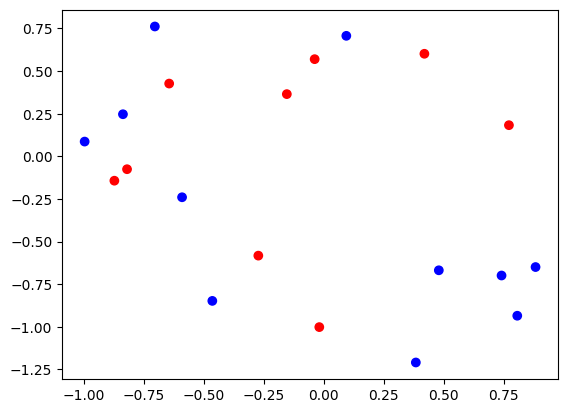

In [16]:
import matplotlib.pyplot as plt

color_list = []

for idx in list(Ytrn):
    if idx == 0:
        color_list.append('blue')
    else:
        color_list.append('red')

plt.scatter(Xtrn[:,0], Xtrn[:,1], color=color_list)

'''
for idx in list(Ytrn_large):
    if idx == 0:
        color_list.append('blue')
    else:
        color_list.append('red')

plt.scatter(Xtrn_large[:,0], Xtrn_large[:,1], color=color_list)
'''


## 1. Build the Classifier $h(x)$ (3 points)

In the following code block, please implement a SVM classifier with the RBF kernel. 


The classifier that we are going to build is the classifier trained on (Xtrn, Ytrn). 


Note that, your implementation should use the exact same arguments as listed in the following `classifier` function. 

You can use the `SVC` function defined in the [sklearn]() package for your implementation, but please keep the default parameters, except the following two

- `kernel`
- `gamma`

With your implementation, please report the prediction accuracy on the test set with the following hyper-parameter values

- `kernel` as `rbf`
- `gamma` as 1

Please print out the accuracy number on the validation set and leave it there for grading. 

In [19]:
from sklearn.svm import SVC

classifier = SVC(kernel='rbf', gamma=1)
classifier.fit(Xtrn, Ytrn)
accuracy = classifier.score(Xtst, Ytst)

print("Accuracy: ", accuracy)


Accuracy:  0.643


## 2 Build the Optimal Classifier $h^{\ast}$ (2 points)

The second classifier that we need is the optimal classifier for a pre-defined hypothesis class. 

In this project, a SVM with the RBF kernal and a specific `gamma` can be considered as one pre-defined hypothesis class. Then, the task is to find the optimal classifier in this class. 

Following the strategy used in the class demo, please implement the code of finding the optimal classifier in the following block. 

You can use the code from the previous block as much as you can, and report the validation accuracy with the following hyper-parameter values

- `kernel` as `rbf`
- `gamma` as 1

Please keep the printed accuracy number for grading purpose.

In [18]:
classifier.fit(Xtrn_large, Ytrn_large)
accuracy = classifier.score(Xtst, Ytst)

print("Accuracy: ", accuracy)


Accuracy:  0.834


## 3 Build the oracle classifier $f$

According to the [make_circles](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html) function, the ground truth decision boundary is the radius = 0.8, which means we can compute the distance between a data point and the origin for predicting its label. 

Please take a look the implementation and make sure you understand how to use it. 

In [20]:
# Please keep this code block unchanged

from numpy.linalg import norm

def f(X, Y, radius):
    d = norm(X, axis=1)
    pred_labels = np.zeros(d.shape)
    pred_labels[np.less_equal(d, radius)] = 1
    acc = (pred_labels == Y).sum() / (1.0*Y.shape[0])
    return acc


def learn_f(Xtst, Ytst, iterations=200):
    ## Use linear search to find the best radius for the classifier $f$
    r_lower, r_upper = 0.7, 1.2
    r_current = (r_lower + r_upper)/2
    thresholds = np.linspace(r_lower, r_upper, iterations)
    accs = []
    for val in thresholds:
        acc = f(Xtst, Ytst, val)
        accs.append(acc)
    idx = np.argmax(accs)
    return accs[idx]


acc_f = learn_f(Xtst, Ytst, iterations=500)
print("The oracle classifier accuracy: {}".format(acc_f))

The oracle classifier accuracy: 0.844


## 4 Bias-Complexity Tradeoff (4 points)

By choosing different degrees of polynomial kernel, essentially we are choosing the hypothesis classes with different complexities. Intuitively, a higher degree gives the hypothesis class with higher complexity. 

In our lecture, we discussed the fundamental tradeoff between the bias and the complexity for a given hypothesis class. 

Similar to the regression case shown in our class demo, the bias term can be measured by the following formula

$$\text{acc}(f) - \text{acc}(h^{\ast})$$

which measures the difference between the optimal classifier from a given hypothesis class (section 2) and the oracle classifier (section 3). 

The complexity term can be measured as the difference between the optimal classifier $h^{\ast}$ and the learned classifier $h$ with limited training examples

$$\text{acc}(h^{\ast}) - \text{acc}(h)$$

In the following code block, please implement these two formula, and report the accuracy differences with the pre-defined gamma's

In [24]:
classifier.fit(Xtrn_large, Ytrn_large)
acc_h_star = classifier.score(Xtst, Ytst)
print("Bias term = acc(f) - acc(h*) = ", acc_f - acc_h_star)

classifier.fit(Xtrn, Ytrn)
acc_h = classifier.score(Xtst, Ytst)
print("Complexity Term = acc(h*) - acc(h) = ", acc_h_star - acc_h)


Bias term = acc(f) - acc(h*) =  0.010000000000000009
Complexity Term = acc(h*) - acc(h) =  0.19099999999999995


**Make sure you also submit the written part**

Please checkout the pdf file for the questions. 


**THE END**

--- 

